# 画像分類のアーキテクチャ

現在でもほとんどの最先端のアーキテクチャの基礎となっている以下のCNNアーキテクチャを見ていきます。

- AlexNet
- VGG
- GoogleNet
- ResNet
- DenseNet

今回からモデルが重くなるため、GoogleColabで実行します。  
(前回まではMPSを使用していたのですが、今回のPytorch Lightningのコード内で解決できないバグがあるようですので、ColabのCuda環境で実行しています)  
以下のボタンをクリックすると、GoogleColabに勝手に移動します。  
リンクは、``https://github.com/``を``https://colab.research.google.com/github``に変更したURLにするだけです。
```
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yoshida-chem/Intro2DL/blob/main/docs/07_image_arch/img_arch.ipynb)
```

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yoshida-chem/Intro2DL/blob/main/docs/07_image_arch/img_arch.ipynb)

In [ ]:
import os
import json
import math
try:
    import japanize_matplotlib
except ModuleNotFoundError:
    !pip install japanize_matplotlib
    import japanize_matplotlib
import numpy as np 
import time
import copy
import requests
from PIL import Image
from types import SimpleNamespace
from io import StringIO

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

from tqdm import tqdm

from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        # GPUありの場合
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    # PytorchLightningでエラーが出るので、MPSはパス
    #elif torch.backends.mps.is_built():
    #    device = torch.device("mps:0")
    else:
        device = torch.device("cpu")
    return device

In [ ]:
# pytorchでデータをダウンロードするときのパス（重複してDWしないため）
DATASET_PATH = "../data"
# モデルの保存先
CHECKPOINT_PATH = "../models/07_image_arch"
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# 再現性のためにseedを固定する
set_seed(42)

# device情報を取得する
device = get_device()
print(f"deviceは{device}です")

deviceはmps:0です


## データ準備

今回は、CIFAR10のデータセットを使用します。。

In [ ]:
# 正規化のための統計値を計算
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


In [ ]:
# 正規化＋FlipとResizeCropのデータ拡張
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

# datasetの準備
# validationではデータ拡張なし
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# 訓練データとバリデーションデータに分割（ここで、同じ分割＆バリデーション時はデータ拡張なし）
set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# dataloaderの準備
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# チャネルごとに正規化できているか確認
imgs, _ = next(iter(train_loader))

# BatchSize, Channel, W, Hの形状を持つ
print(imgs.shape)
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

torch.Size([128, 3, 32, 32])
Batch mean tensor([0.0231, 0.0006, 0.0005])
Batch std tensor([0.9865, 0.9849, 0.9868])


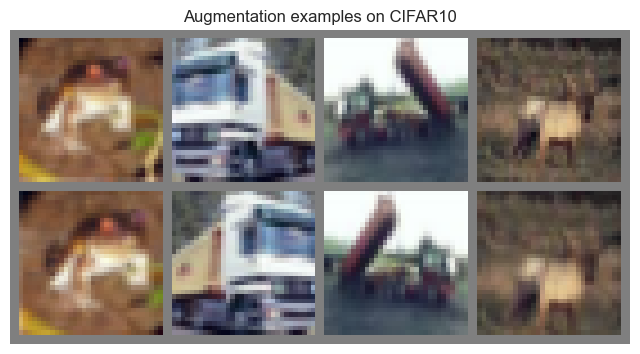

In [ ]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
# transformする場合は、Image Typeに変換する必要あり
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [train_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## アーキテクチャの実装

準備として活性化関数がまとまった辞書を作っておきます。これは後述のPytorch Lightningでハイパーパラメータを保存したいためです。（Objectを引数にすると保存されない）

In [7]:
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

### AlexNet

AlexNetは、画像認識のコンテストILSVRC 2012で優勝したモデルです。AlexNetは５つの畳み込み層と３つのプーリング層、２つのコントラスト正規化、３つの全結合層により構成されています。学習では、fc6とfc7の層のユニットにドロップアウト(p=0.5)が用いられています。また、各CNN層とFC層の後にはReLUが使用されています。また、Local Response Normを第一と第二のCNN層の後のReLUの後に適応しています。これは汎化性能を上げたようですが、現在のBatch Normalizationが開発前なためこちらが使われているようです。

また、元論文では当時のGPUの性能からブロックを２つに分けているので、今回は１つにまとめます。
詳しくは、元論文の3.5 Overall Architectureを参考にしてください。

<img src="https://raw.githubusercontent.com/yoshida-chem/Intro2DL/main/docs/07_image_arch/alexnet.png" alt="AlexNet" title="AlexNet">

https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

In [8]:
class AlexNet(nn.Module):

    def __init__(self, num_classes, act_fn_name="relu"):
        super().__init__()

        # self.hparams.name でアクセスしたいので、SimpleNamespaceを使用
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()
    
    def _create_network(self):
        self.features = nn.Sequential(
            # 1st layer
            ## channel48*2をまとめてchannel=96にしている。また、WとHのサイズを合わせるためにpadding=2へ変更
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2),
            self.hparams.act_fn(),
            ## ハイパーパラメータは元論文中でバリデーションを元に決められています
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 2nd layer
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            self.hparams.act_fn(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 3-5rd layer
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            self.hparams.act_fn(),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            self.hparams.act_fn(),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            self.hparams.act_fn(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=256*6*6, out_features=4096),
            self.hparams.act_fn(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            self.hparams.act_fn(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=self.hparams.num_classes),
        )

    def _init_params(self):
        # 元論文とは異なる初期化
        # 活性化関数に基づきConv2dの初期化を行う
        # ResNetではmode="fan_out"出力側で計算を選択されているが、ここではデフォルトのfan_inを選択
        # https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L156 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity=self.hparams.act_fn_name)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

In [9]:
# 実装中のサイズの確認
# N * C * W * H
tmp = torch.rand(1, 3, 224, 224)
print(tmp.shape)

cnn = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2)
tmp_ = cnn(tmp)
print(tmp_.shape)

net = AlexNet(num_classes=10, act_fn_name="relu")
tmp_ = net(tmp)
print(tmp_.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 96, 55, 55])
torch.Size([1, 10])


### VGG

VGGは、ILSVRC2014で提案されたモデルで、16層または19層からなるCNNを使用したモデルになります。  
VGGNetはAlexNetを大規模にしたもので、3*3のフィルタを使用することで活性化関数の適用回数が増え表現力が増加しています。AlexNetと比較するとコントラスト正規化層がなくなっています。

欠点としては、Global Average Pooling層がないため、全結合層の箇所のパラメータが多くなり計算が重い点です。
今回は、下記画像のDであるVGG16を実装しました。VGG19は後半３つのCNN層が１つずつ多くなる点が異なります。

<img src="https://raw.githubusercontent.com/yoshida-chem/Intro2DL/main/docs/07_image_arch/vggnet.png" alt="VGGNet" title="VGGNet">

https://arxiv.org/pdf/1409.1556.pdf

In [10]:
class VGG16Net(nn.Module):

    def __init__(self, num_classes, act_fn_name="relu"):
        super().__init__()

        # self.hparams.name でアクセスしたいので、SimpleNamespaceを使用
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()
    
    def _create_network(self):
        self.features = nn.Sequential(
            # 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            self.hparams.act_fn(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            self.hparams.act_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            self.hparams.act_fn(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            self.hparams.act_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            self.hparams.act_fn(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            self.hparams.act_fn(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            self.hparams.act_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            # 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            self.hparams.act_fn(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            self.hparams.act_fn(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            self.hparams.act_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            # 5
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            self.hparams.act_fn(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            self.hparams.act_fn(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            self.hparams.act_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=512*7*7, out_features=4096),
            self.hparams.act_fn(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            self.hparams.act_fn(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=self.hparams.num_classes),
        )

    def _init_params(self):
        # 元論文とは異なる初期化
        # 活性化関数に基づきConv2dの初期化を行う
        # ResNetではmode="fan_out"出力側で計算を選択されているが、ここではデフォルトのfan_inを選択
        # https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L156 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity=self.hparams.act_fn_name)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

In [11]:
# 実装中のサイズの確認
# N * C * W * H
tmp = torch.rand(1, 3, 224, 224)
print(tmp.shape)

net = VGG16Net(num_classes=10, act_fn_name="relu")
tmp_ = net(tmp)
print(tmp_.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 10])


### GoogleNet

VGGがILSVRC2014で二位を獲得した際の優勝したモデルであるGoogleNetを実装します。
Inception Blockとglobal average pooling(GAP)が特徴的なアーキテクチャです。

#### Inception Block

Inceptionブロックは、同じ特徴マップに対して、1x1、3x3、5x5のCNNと、Max Poolingという4つのブロックを別々に適用します。これにより、ネットワークは同じデータを異なる受容野で見ることができます。また、実装では1x1のCNN(ボトルネック層やPointwise Convolutionとも呼ばれているCNN層)を挟むことで、まずチャンネル方向の畳込みを行った後に縦横方向の畳込みを行うことができ、分割して計算をすることになるため演算量を削減できています。もちろん、5x5の畳み込みだけを学習する方が理論的には強力ですが、これはより計算とメモリが重いだけでなく、オーバーフィットしやすくなる傾向があります。  

<img src="https://raw.githubusercontent.com/yoshida-chem/Intro2DL/main/docs/07_image_arch/Inception.png" alt="Inception" title="Inception">

全体のインセプションブロックは以下のように実装できます。

In [12]:
class InceptionBlock(nn.Module):
    
    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()
        
        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )
        
        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )
        
        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )
        
        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        # 連結
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

上記のInception Blockを用いてGoogleNetを実装します。元論文では以下のようなかなり大きなモデルですが、今回はMNISTの簡単な問題を解きたいだけなので縮小して実装されています。また、Batch Normalizationはこの後のResNetで提案されたものですが、今回の実装ではGoogleNetにも使用されている点も注意してください。

#### Global Average Pooling（GAP） 
GAPは、各チャンネルの値の平均を算出することでパラメータ数を削減します。各チャネルごとの平均により、過学習を抑制することが期待できます。また、出力されたニューロンの数がチャネル数飲みに依存するので、入力の画像サイズに依存しなくなるという特徴もあります。  
ResNetでも使用されている方法ですが、Pytorchで直接実装されていないので``nn.AdaptiveAvgPool2d((1,1))``として使用する必要があります。https://www.テクめも.com/entry/pytorch-pooling

<img src="https://raw.githubusercontent.com/yoshida-chem/Intro2DL/main/docs/07_image_arch/GoogleNet.png" alt="googlenet" title="googlenet">


In [13]:
class GoogleNet(nn.Module):

    def __init__(self, num_classes=10, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        # チャネルサイズを上げる
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        # Inception Blocks
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn)
        )
        # 出力
        self.output_net = nn.Sequential(
            # Linearで繋げる場合はC*W*Hのサイズが必要だったが、GAPがあることでチャネル数C=128のみになり計算量削減
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams.num_classes)
        )

    def _init_params(self):
        # 活性化関数に基づき初期化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

In [14]:
# 実装中のサイズの確認
# N * C * W * H
tmp = torch.rand(1, 3, 224, 224)
print(tmp.shape)

net = GoogleNet(num_classes=10, act_fn_name="relu")
tmp_ = net(tmp)
print(tmp_.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 10])


### ResNet

#### 残差接続

残差接続では、$x_{l+1} = F(x_l)$をモデル化する代わりに、$x_{l+1} = x_l + F(x_l)$をモデル化します。ここで、$F()$は非線形関数です。このような残差接続に対して勾配を計算すると、以下のようになり$F$の影響を受けにくく安定した勾配伝播が可能になります。実装上の注意点としては、$x_l$と$F(x_l)$を足し算する必要があるので、$F()$で解像度を下げた場合は特徴マップの形状が同じになるように変換が必要である点です。

$$
\partial x_{l+1}/\partial x_l = I + \partial F(x_l)/\partial x_l 
$$

ResNetにはいくつかのバージョンが提案されているので、ここでは3つ見ていきます。

- Original ResNet block：スキップコネクションの後にReLUを適用する。元論文の実装。
- Pre-Activation ResNet block：Fの初めの段階でReLUを適用する。より深いネットワークでは上記のように勾配流が恒等行列を持つことを保証できるため、こちらの方が良いことが知られています。(下図; https://arxiv.org/abs/1603.05027)
- BottleNeckを持つResNet block：計算量を増やすことなくブロック内のチャネル数を増やす狙い。Inception Block同様に計算量を削減するために1x1のCNNが使用されている。

<img src="https://raw.githubusercontent.com/yoshida-chem/Intro2DL/main/docs/07_image_arch/residual-block.png" alt="resblock" title="resblock">

In [15]:
class OriginalResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - Trueの場合、関数F内でstride=2にすることで解像度を下げる。Falseの場合そのまま。
            c_out - subsample=Trueの場合のみ、有効。Falseの場合、入力と同じ。
        """
        super().__init__()
        if not subsample:
            c_out = c_in
            
        # 上記の説明における関数F
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),  # No bias needed as the Batch Norm handles it
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out)
        )
        
        # 1x1 convolution with stride 2 により、元の入力のサイズを下げる 
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

    def forward(self, x):
        # F(x)
        z = self.net(x)
        # x : stride=2で解像度下がる場合、形状を同じにする
        if self.downsample is not None:
            x = self.downsample(x)
        # skip connection
        out = x + z
        # skip connectionの後にReLUがくる
        out = self.act_fn(out)
        return out

In [16]:
class PreActResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - Trueの場合、関数F内でstride=2にすることで解像度を下げる。Falseの場合そのまま。
            c_out - subsample=Trueの場合のみ、有効。Falseの場合、入力と同じ。
        """
        super().__init__()
        if not subsample:
            c_out = c_in
            
        # 上記の説明における関数F
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            # skip connection の最初の段階でReLUを適用
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False)
        )
        
        # 1*1 CNNを適用する場合は非線形性を適用する必要あり 
        self.downsample = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, stride=2, bias=False)
        ) if subsample else None

    def forward(self, x):
        # F(x)
        z = self.net(x)
        # x : stride=2で解像度下がる場合、形状を同じにする
        if self.downsample is not None:
            x = self.downsample(x)
        # skip connection
        out = x + z
        return out

In [17]:
class BottleNeckResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1, **kwargs):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - Trueの場合、関数F内でstride=2にすることで解像度を下げる。Falseの場合そのまま。
            c_out - Number of output features.論文中では、c_out = c_in*4 とされています
            https://arxiv.org/pdf/1512.03385.pdf
        """
        super().__init__()
            
        # 上記の説明における関数F
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_in, kernel_size=1, padding=1, stride=1 if not subsample else 2, bias=False),  # No bias needed as the Batch Norm handles it
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_in, kernel_size=3, padding=1),  # No bias needed as the Batch Norm handles it
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, padding=1, bias=False),
            nn.BatchNorm2d(c_out)
        )
        
        # 1x1 convolution with stride 2 により、元の入力のサイズを下げる
        # また、BottleNeckタイプは最後のチャネル数が２５６になったりするので変更 
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=1 if not subsample else 2)
        self.act_fn = act_fn()

    def forward(self, x):
        # F(x)
        z = self.net(x)
        # x : stride=2で解像度下がる場合、形状を同じにする
        if self.downsample is not None:
            x = self.downsample(x)
        # skip connection
        out = x + z
        # skip connectionの後にReLUがくる
        out = self.act_fn(out)
        return out

In [18]:
resnet_blocks_by_name = {
    "ResNetBlock": OriginalResNetBlock,
    "PreActResNetBlock": PreActResNetBlock,
    "BottleNeckResNetBlock": BottleNeckResNetBlock
}

ResNet全体のアーキテクチャは、複数のResNetブロックを積み重ねることで構成されており、そのうちのいくつかは入力をダウンサンプリングしています。ネットワーク全体のResNetブロックについて話すとき通常、同じ出力形状でグループ化します。つまり、ResNetが[3,3,3]のブロックを持つということは、3つのResNetブロックのグループを3回重ね、4番目と7番目のブロックでサブサンプリングが行われていることを意味しています。

In [19]:
class ResNet(nn.Module):

    def __init__(self, num_classes=10, num_blocks=[3,3,3], c_hidden=[16,32,64], act_fn_name="relu", block_name="ResNetBlock", **kwargs):
        """
        Inputs: 
            num_classes - Number of classification outputs (10 for CIFAR10)
            num_blocks - List with the number of ResNet blocks to use. The first block of each group uses downsampling, except the first.
            c_hidden - List with the hidden dimensionalities in the different blocks. Usually multiplied by 2 the deeper we go.
            act_fn_name - Name of the activation function to use, looked up in "act_fn_by_name"
            block_name - Name of the ResNet block, looked up in "resnet_blocks_by_name"
        """
        super().__init__()
        assert block_name in resnet_blocks_by_name
        self.hparams = SimpleNamespace(num_classes=num_classes, 
                                       c_hidden=c_hidden, 
                                       num_blocks=num_blocks, 
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name],
                                       block_class=resnet_blocks_by_name[block_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.c_hidden
        
        # A first convolution on the original image to scale up the channel size
        if self.hparams.block_class == PreActResNetBlock: # => Don't apply non-linearity on output
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False)
            )
        else:
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(c_hidden[0]),
                self.hparams.act_fn()
            )
        
        # Creating the ResNet blocks
        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0) # Subsample the first block of each group, except the very first one.
                blocks.append(
                    self.hparams.block_class(c_in=c_hidden[block_idx if not subsample else (block_idx-1)],
                                             act_fn=self.hparams.act_fn,
                                             subsample=subsample,
                                             c_out=c_hidden[block_idx])
                )
        self.blocks = nn.Sequential(*blocks)
        
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        # Fan-out focuses on the gradient distribution, and is commonly used in ResNets
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

### DenseNet

DenseNetは、ResNetとは少し異なる方法でskip connectionを用いることで冗長な特徴マップを学習する必要性を排除しています。  
ネットワークに深く入り込むと、モデルはパターンを認識するために抽象的な特徴を学習します。しかし、複雑なパターンの中には、抽象的な特徴（手、顔など）と低レベルの特徴（エッジ、基本色など）の組み合わせで構成されているものがあるため、このような低レベルの特徴を深い層で見つけるためには、再度学習しなければならず無駄になります。  
DenseNetは、以下の図のように各畳み込みが以前のすべての入力特徴マップを少量のフィルターを増やす(増やすフィルターの数$k$は、成長率パラメータ(Growth rate)と呼ばれています)だけでに、特徴を再利用することができる効率的な方法になります。(https://arxiv.org/pdf/1608.06993.pdf)   
また、一番最後の層はTransition Layerと呼ばれる層で、特徴マップの高さ、幅、チャンネルの大きさの次元を減らす役割を担っています。

<img src="https://raw.githubusercontent.com/yoshida-chem/Intro2DL/main/docs/07_image_arch/denseblock.png" alt="denseblock" title="denseblock">

実装としては、DenseBlockとDenseBlockを構成するDenseLayer、DenseBlockの一番最後の層であるTransition Layerで構成されます。

<img src="https://raw.githubusercontent.com/yoshida-chem/Intro2DL/main/docs/07_image_arch/densenet.png" alt="densenet" title="densenet">

In [20]:
class DenseLayer(nn.Module):
    
    def __init__(self, c_in, bn_size, growth_rate, act_fn):
        """
        Inputs:
            c_in - Number of input channels
            bn_size - Bottleneck size (factor of growth rate) for the output of the 1x1 convolution. Typically between 2 and 4.
            growth_rate - Number of output channels of the 3x3 convolution
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, bn_size * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm2d(bn_size * growth_rate),
            act_fn(),
            nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        )
        
    def forward(self, x):
        out = self.net(x)
        # 出力チャネルは入力のオリジナルと連結される
        out = torch.cat([out, x], dim=1)
        return out

In [21]:
class DenseBlock(nn.Module):
    
    def __init__(self, c_in, num_layers, bn_size, growth_rate, act_fn):
        """
        Inputs:
            c_in - Number of input channels
            num_layers - Number of dense layers to apply in the block
            bn_size - Bottleneck size to use in the dense layers
            growth_rate - Growth rate to use in the dense layers
            act_fn - Activation function to use in the dense layers
        """
        super().__init__()
        layers = []
        for layer_idx in range(num_layers):
            layers.append(
                # 以前の全ての層の特徴マップを連結した元の入力を入力とする
                # 出力は：c_out = c_in + layer_idx * growth_rate + growth_rateになる 
                DenseLayer(c_in=c_in + layer_idx * growth_rate, 
                           bn_size=bn_size,
                           growth_rate=growth_rate,
                           act_fn=act_fn)
            )
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.block(x)
        return out

In [22]:
class TransitionLayer(nn.Module):
    
    def __init__(self, c_in, c_out, act_fn):
        super().__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            # 1*1 CNNでチャネル方向の次元削減
            nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
            # 高さと幅を削減するために、カーネルサイズ2とストライド2の平均プーリングを適用する
            nn.AvgPool2d(kernel_size=2, stride=2) # Average the output for each 2x2 pixel group
        )
        
    def forward(self, x):
        return self.transition(x)

上記を使用してDenseNetを構築していきます。

In [23]:
class DenseNet(nn.Module):
    
    def __init__(self, num_classes=10, num_layers=[6,6,6,6], bn_size=2, growth_rate=16, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       num_layers=num_layers,
                                       bn_size=bn_size,
                                       growth_rate=growth_rate,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()
        
    def _create_network(self):
        c_hidden = self.hparams.growth_rate * self.hparams.bn_size # The start number of hidden channels
        
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden, kernel_size=3, padding=1) # No batch norm or activation function as done inside the Dense layers
        )
        
        # Creating the dense blocks, eventually including transition layers
        blocks = []
        for block_idx, num_layers in enumerate(self.hparams.num_layers):
            blocks.append( 
                DenseBlock(c_in=c_hidden, 
                           num_layers=num_layers, 
                           bn_size=self.hparams.bn_size,
                           growth_rate=self.hparams.growth_rate,
                           act_fn=self.hparams.act_fn)
            )
            # denseblockの出力 = c_in + blockの層の数 * growth_rate
            c_hidden = c_hidden + num_layers * self.hparams.growth_rate 
            if block_idx < len(self.hparams.num_layers)-1: # Don't apply transition layer on last block
                blocks.append(
                    TransitionLayer(c_in=c_hidden,
                                    c_out=c_hidden // 2,
                                    act_fn=self.hparams.act_fn))
                c_hidden = c_hidden // 2
                
        self.blocks = nn.Sequential(*blocks)
        
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.BatchNorm2d(c_hidden), # The features have not passed a non-linearity until here.
            self.hparams.act_fn(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

## Pytorch Lightning

Pytorch Lightningを使用することで、細かいコードを書かなくても良くなるのでより本質的な作業に時間を費やすことができるようになります。
例えば、``to_device``を書かなくてもいいので、その分実装も楽です。

ここでは、``pl.LightningModule（torch.nn.Moduleを継承）``を継承します。このクラスは5つの主要なメソッドを持ちます。もしこれら以外のコードを変更する場合は、overwriteできる関数があるので、ドキュメントを参照します。  

- 初期化(__init__): 必要なパラメータやモデルを作成します
- オプティマイザ(configure_optimizers): オプティマイザ、学習率スケジューラなどを作成します
- トレーニングループ(training_step)：単一バッチの損失計算を定義するだけ（optimizer.zero_grad(), loss.backward() および optimizer.step() のループ。ログ記録/保存操作はバックグラウンドで行われます）。
- 検証ループ(validation_step) 訓練と同様に、ステップごとに何が起こるかを定義するだけです
- テストループ(test_step): 検証と同じで、テストセットに対してのみ行われます

参考：https://qiita.com/ground0state/items/c1d705ca2ee329cdfae4   
参考：https://tech.jxpress.net/entry/2021/11/17/112214

In [ ]:
try:
  import pytorch_lightning as pl
except ModuleNotFoundError:
  !pip install pytorch_lightning
  import pytorch_lightning as pl
from torchmetrics import Accuracy, Precision, Recall, F1Score, MetricCollection

# pytorch lightningでは以下のコードでSeedを固定できます
pl.seed_everything(42)

Global seed set to 42


42

In [25]:
model_dict = {
    "AlexNet": AlexNet,
    "VGG16Net": VGG16Net,
    "GoogleNet": GoogleNet,
    "ResNet": ResNet,
    "DenseNet": DenseNet
}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

In [29]:
class CIFARModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

        self.train_metrics = MetricCollection([Accuracy(), Precision(), Recall(), F1Score()], prefix='train_')
        self.val_metrics = MetricCollection([Accuracy(), Precision(), Recall(), F1Score()], prefix='val_')
        self.test_metrics = MetricCollection([Accuracy(), Precision(), Recall(), F1Score()], prefix='test_')

    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(
                self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        #acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        #self.log('train_acc', acc, on_step=False, on_epoch=True)
        #preds_for_metrics = preds.argmax(dim=-1)
        #self.train_metrics(preds_for_metrics, labels)
        #self.log_dict(self.train_metrics, on_step=False, on_epoch=True)

        self.log('train_loss', loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        preds_for_metrics = preds.argmax(dim=-1)
        loss = self.loss_module(preds, labels)
        self.log('val_loss', loss)
        #acc = (labels == preds_for_metrics).float().mean()
        # By default logs it per epoch (weighted average over batches)
        #self.log('val_acc', acc)
        #self.val_metrics(preds_for_metrics, labels)
        #self.log_dict(self.val_metrics)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        self.log('test_loss', loss)

        #preds_for_metrics = self.model(imgs).argmax(dim=-1)
        #self.test_metrics(preds_for_metrics, labels)
        #self.log_dict(self.test_metrics)
        #acc = (labels == preds_for_metrics).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        #self.log('test_acc', acc)

In [ ]:
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping

def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name
        
    # Create a PyTorch Lightning trainer with the generation callback
    if str(device) == "mps:0":
        trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         accelerator="mps" if str(device)=="mps:0" else "cpu",
                         devices=1 if str(device)=="mps:0" else 0,                                           # We run on a single GPU (if possible)
                         max_epochs=30,                                                                     # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch"),                                            # Log Learning raate every epoch
                                    EarlyStopping(monitor="val_loss", mode="min")],                          # early stopping
                         enable_progress_bar=True)    
    else:
        trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         gpus=1 if str(device)=="cuda:0" else 0,
                         devices=1,                                        # We run on a single GPU (if possible)
                         max_epochs=30,                                                                     # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch"),                                            # Log Learning raate every epoch
                                    EarlyStopping(monitor="val_loss", mode="min")],                          # early stopping
                         enable_progress_bar=True)   
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = CIFARModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = CIFARModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CIFARModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training
        
    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
    
    return model, result

## 各モデルの訓練

In [ ]:
googlenet_model, googlenet_results = train_model(model_name="GoogleNet", 
                                                 model_hparams={"num_classes": 10, 
                                                                "act_fn_name": "relu"}, 
                                                 optimizer_name="Adam",
                                                 optimizer_hparams={"lr": 1e-3,
                                                                    "weight_decay": 1e-4})

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yyamaguchi/Desktop/programming/Intro2DL/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
Global seed set to 42

  | Name          | Type             | Params | In sizes       | Out sizes
--------------------------------------------------------------------------------
0 | model         | GoogleNet        | 260 K  | [1, 3, 32, 32] | [1, 10]  
1 | loss_module   | CrossEntropyLoss | 0      | ?              | ?        
2 | train_metrics | MetricCollection | 0      | ?              | ?        
3 | val_metrics   | MetricCollection | 0      | ?              | ?        
4 | test_metrics  | MetricCollection | 0      | ?              | ?        
--------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/yyamaguchi/Desktop/programming/Intro2DL/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


IsADirectoryError: [Errno 21] Is a directory: '/Users/yyamaguchi/Desktop/programming/Intro2DL/docs/07_image_arch'